In [1]:
import sys 
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import dill
from scipy.stats import binom
from TestModel import TestModel
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
#%matplotlib notebook

# Graph 3 and 4

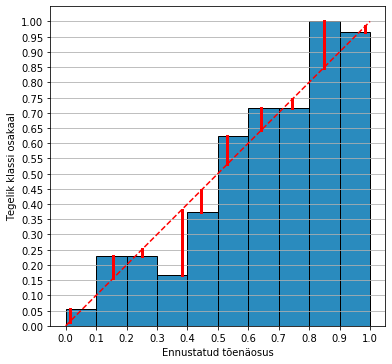

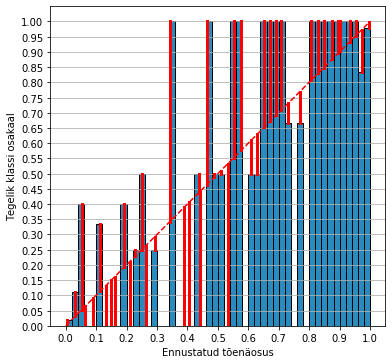

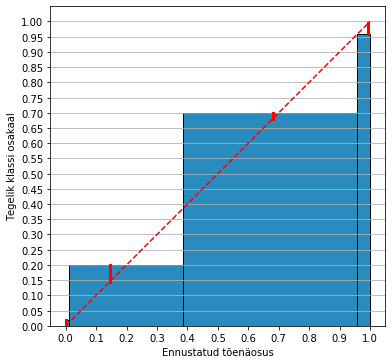

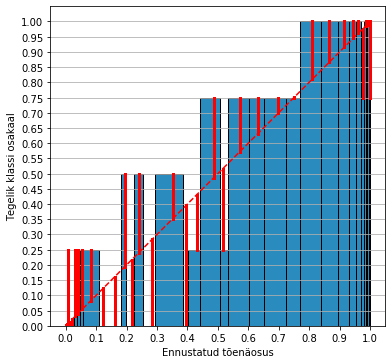

[0.09335482122250008]

In [28]:
def draw_reliability_diagram(bins, equal_width_bins, n_bins, title="", draw_colorbar=False, name="rel_diag.png"):
    
    # Actual proportions of class labels in each bin
    
    actual_proportions = []
    n_data_points = 0
    for b in bins:
        b = np.asarray(b)
        bin_size = len(b)
        n_data_points += bin_size
        
        if bin_size == 0:
            actual_proportions.append(0.0)
        else:
            actual_proportions.append(b[:, 1].mean())
    
    # Bin coordinates 
    
    if equal_width_bins:
        bin_coords = np.arange(0, 1, 1.0 / n_bins)

    else:
        bin_coords = [0.0]
        for b in bins:
            bin_coords.append(b[:, 0].max())
        bin_coords = bin_coords[:-1]
        
    bin_coords = np.append(bin_coords, 1.0)
    
    # Bin widths
    
    bin_widths = []
    for i in range(len(bin_coords) - 1):
        bin_widths.append(bin_coords[i + 1] - bin_coords[i])
    bin_coords = bin_coords[:-1]
    
    # Bin color
    
    bin_color = []
    for b in bins:
        bin_color.append(len(b) / n_data_points)
    
    # Figure

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.title(title)
    plt.xlabel("Ennustatud tõenäosus")
    plt.ylabel("Tegelik klassi osakaal")
    plt.yticks([i / 100 for i in range(0, 102, 5)])
    ax.grid(axis="y")
    
    # Colormap
    
    cmap = plt.cm.get_cmap('GnBu')
    cmap = ListedColormap(cmap(np.linspace(0.75, 0.75, 100)))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, np.max(bin_color)))
    if draw_colorbar:
        cbar = plt.colorbar(sm, fraction=0.04, pad=0.04)
        cbar.set_label('Proportion of datapoints in bin', rotation=270,labelpad=25)
    c = sm.to_rgba(bin_color)

    
    ticks = [x for x in bin_coords]
    tick_labels = [0.0] + [round(x,2) for x in bin_coords][1:] + [1.0]
    ticks.append(1.0)

    ticks = np.round(np.arange(0, 1.01, 0.1), 2)
    tick_labels = np.round(np.arange(0, 1.01, 0.1), 2)

    plt.bar(bin_coords,
            actual_proportions,
            bin_widths,
            color = c,
            edgecolor=(0.0,0.0,0.0),
            align="edge",
            tick_label=None)
    plt.xticks(ticks, tick_labels)
    ax.plot([0, 1], [0, 1], 'r--')
    
    # Miscalibration bars
    
    for i in range(n_bins):
        x_coord = bin_coords[i] + bin_widths[i] / 2.0
        y1_coord = x_coord
        y2_coord = actual_proportions[i]
        if len(bins[i]) != 0:
            b = np.mean(np.asarray(bins[i])[:,0])
            y1_coord = b
            y2_coord = actual_proportions[i]
            ax.plot([b, y1_coord], [b, y2_coord], 'r-', linewidth=3)

    plt.savefig(name, bbox_inches='tight', dpi=300)
    plt.show()
    
def class_J_ECE(class_J_predictions, is_J_class, n_bins = 10, equal_width_bins = True, draw_diagram = False, class_name="0"):
    
    data = np.array((class_J_predictions, is_J_class)).T
      
    # Dividing data into bins
    
    if equal_width_bins:
        bins = [[] for i in range(n_bins)]
        bin_width = 1.0 / n_bins

        for d in data:
            idx = int(d[0] // bin_width)
            bins[idx].append(d)
        
    else: 
        sorted_data = data[data[:, 0].argsort()]
        bins = np.array_split(sorted_data, n_bins)
        
    # ECE calculation
          
    ECE_score = 0
    n_data_points = len(class_J_predictions)
    for b in bins:
        b = np.asarray(b)
        bin_size = len(b)
        if bin_size == 0:
            continue
        average_predictions_in_bin = b[:, 0].mean()
        actual_proportion_in_bin = b[:, 1].mean()
        
        ECE_score += abs(actual_proportion_in_bin - average_predictions_in_bin) *  bin_size / n_data_points
        
    
    # Reliability diagram
    
    if draw_diagram:
        draw_reliability_diagram(bins, 
                                 equal_width_bins, 
                                 n_bins, 
                                 title= class_name + ". ECE " + str(round(ECE_score, 4)), name=class_name+".png")
    
    return ECE_score

def classwise_ECE(predictions, labels, n_bins = 10, equal_width_bins = True, draw_diagram = False):    
    
    ECE_score = 0
    n_classes = len(predictions[0])
    
    for class_label in range(0, n_classes, 1):
        class_J_predictions = predictions[:, class_label]
        is_J_class = labels == class_label
        
        if class_label == 1:
            class_J_ECE(class_J_predictions,
                         is_J_class, 
                         10,
                         True,
                         draw_diagram,
                         class_name="graph4_1")
            class_J_ECE(class_J_predictions,
                         is_J_class, 
                         50,
                         True,
                         draw_diagram,
                         class_name="graph4_2") 
            class_J_ECE(class_J_predictions,
                         is_J_class, 
                         4,
                         False,
                         draw_diagram,
                         class_name="graph4_3") 
            class_J_ECE(class_J_predictions,
                         is_J_class, 
                         50,
                         False,
                         draw_diagram,
                         class_name="graph4_4") 
        
        ECE_score += class_J_ECE(class_J_predictions,
                                 is_J_class, 
                                 n_bins,
                                 equal_width_bins,
                                 False,
                                 class_name="Class " + str(class_label)) / n_classes
    
    return ECE_score

def sample_ECE_distribution(times, n_classes, n_data_points, alpha, 
                            n_bins = 10, equal_width_bins = True, 
                            use_classwise_ECE = True, draw_diagram = False, dirichlet=[0.1]):
    
    if dirichlet == [0.1]:
        dirichlet = [0.1] * n_classes
    
    scores = []
    for i in range(times):
        
        predictions = np.random.dirichlet(dirichlet, n_data_points)
        
        labels_c1 = np.array([np.random.choice(range(0, n_classes, 1), p=preds) for preds in predictions])
        labels_c2 = np.array([np.random.choice(range(0, n_classes, 1), p=[1.0 / n_classes] * n_classes) for i in range(n_data_points)])
        
        break_point = int(n_data_points * alpha)
        labels = np.append(labels_c1[:break_point], labels_c2[break_point:])
        
        if use_classwise_ECE:
            scores.append(classwise_ECE(predictions, labels, n_bins, equal_width_bins, draw_diagram))
        else:
            scores.append(confidence_ECE(predictions, labels, n_bins, equal_width_bins, draw_diagram))

    return scores

sample_ECE_distribution(times=1, 
                        n_classes = 2,
                        n_data_points = 200,
                        alpha = 0.95,
                        n_bins = 40,
                        equal_width_bins = True, 
                        use_classwise_ECE = True,
                        draw_diagram = True,
                       dirichlet=[0.2, 0.18])

# Graph 5

1.9448889904994154e-05

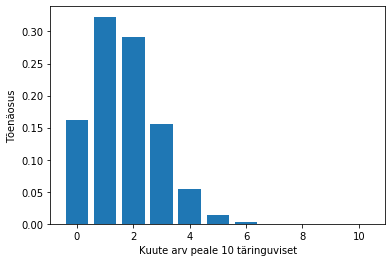

In [39]:
n = 10
p = 1/6
rv = binom(n, p)
x = [i for i in range(0, n+1, 1)]
y = [rv.pmf(i) for i in x] 
plt.xlabel("Kuute arv peale 10 täringuviset")
plt.ylabel("Tõenäosus")
plt.bar(x, y)
plt.savefig('graph5.png',bbox_inches='tight', dpi=300)
rv.pmf(9)+ rv.pmf(10)+ rv.pmf(8)

# Graph 6 and 7

In [2]:
def p_value(at_value, values, len_values):
    return sum(np.asarray(values) >= at_value) / len_values

In [52]:
n_classes = 2
n_data_points = 100
alpha = 0.95
type = "dirichlet01"
ECE_calc="absolute"
model = TestModel(0, n_classes, type, alpha, ECE_calc=ECE_calc, decalibration="method1", n_data_points=n_data_points)

In [42]:
a = model.resampling_test(1000, 15, True, True)

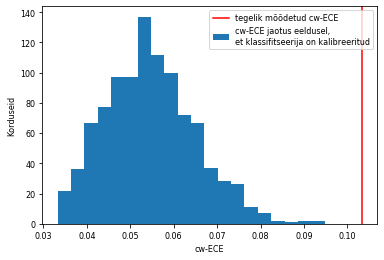

1.0

In [43]:
plt.hist(a[1], bins=20)
plt.axvline(a[0], color="r")
plt.legend(["tegelik mõõdetud cw-ECE","cw-ECE jaotus eeldusel, \net klassifitseerija on kalibreeritud"])
plt.xlabel("cw-ECE")
plt.ylabel("Korduseid")
plt.savefig('graph6.png',bbox_inches='tight', dpi=300)
plt.show()
p_value(a[1], a[0], 1000)

In [53]:
a = model.resampling_test(1000, 15, True, True)

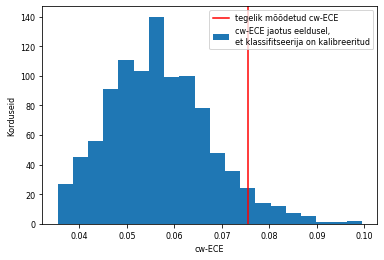

0.945

In [54]:
plt.hist(a[1], bins=20)
plt.axvline(a[0], color="r")
plt.legend(["tegelik mõõdetud cw-ECE","cw-ECE jaotus eeldusel, \net klassifitseerija on kalibreeritud"])
plt.xlabel("cw-ECE")
plt.ylabel("Korduseid")
plt.savefig('graph7.png',bbox_inches='tight', dpi=300)
plt.show()
p_value(a[1], a[0], 1000)

# Graph 8

In [106]:
b10_test = model.resampling_test_p_value_distribution(p_values_per_distribution, 
                                                                 resampling_tests_per_value,
                                                                 n_bins=10, 
                                                                 equal_width_bins=eq_width_bins, 
                                                                 use_classwise_ECE=cw_ECE)

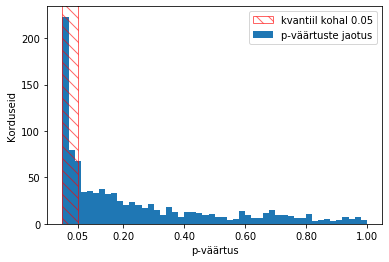

0.33899999999999997

In [49]:
fig,ax = plt.subplots(figsize=(6,4))

plt.hist(b10_test, bins=50)

rect = patches.Rectangle((0,0),0.05,250,linewidth=1,edgecolor='r',facecolor="None", alpha=0.6, hatch=r"\\")
ax.add_patch(rect)
plt.xlabel("p-väärtus")
plt.ylabel("Korduseid")

plt.xticks([0.05, 0.2, 0.4, 0.6, 0.8, 1.0])


plt.legend(["kvantiil kohal 0.05","p-väärtuste jaotus"])
plt.savefig('pvalue_distr.png',bbox_inches='tight', dpi=300)
plt.show()

1-p_value(0.05, b10_test, 1000)

# Graph 9

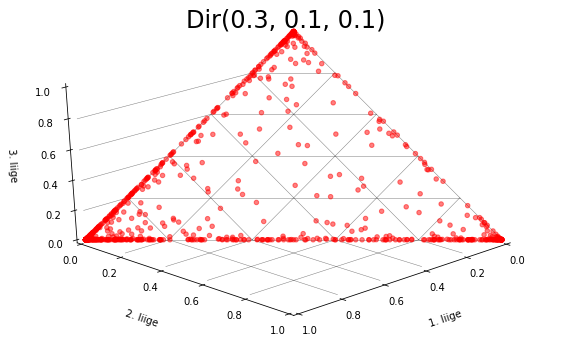

In [7]:
x=0.3
y=0.1
z=0.1
samples = np.random.dirichlet([x,y,z], 1000)

fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')

a = 0.5
c = "black"
lw = 0.5
for i in np.arange(0, 1, 0.2):
    ax.plot([0, 1-i], [1-i, 0], [i, i], color=c, alpha=a, lw=lw)
    ax.plot([i,i], [1-i, 0], [0,1-i], color=c, alpha=a, lw=lw)
    ax.plot([0, 1-i], [i,i], [1-i,0], color=c, alpha=a, lw=lw)
    
    ax.plot([i,i], [1,1-i], [0,0], color=c, alpha=a, lw=lw)
    ax.plot([1,1-i], [i,i], [0,0], color=c, alpha=a, lw=lw)
    ax.plot([1,1-i], [0,0], [i,i], color=c, alpha=a, lw=lw)


ax.scatter(samples[:,0], samples[:,1], samples[:,2], marker="o", s=20, color="red",alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.set_zlim(0, 1)

m=24
s=16
plt.rc('axes', titlesize=m)     # fontsize of the axes title
plt.rc('axes', labelsize=s)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=s)    # fontsize of the tick labels
plt.rc('ytick', labelsize=s)    # fontsize of the tick labels

ax.set_xlabel('1. liige')
ax.set_ylabel('2. liige')
ax.set_zlabel('3. liige')

ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 10

ax.view_init(elev=30, azim=45)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(False)

plt.title("Dir({}, {}, {})".format(x,y,z))
plt.show()
#plt.savefig("dir{}{}{}.png".format(x,y,z),bbox_inches='tight', dpi=300)

# Graph 10

In [2]:
folder = "../tests/"

with open(folder+'T1.pkl', 'rb') as file:
    d1 = dill.load(file)
with open(folder+'T2.pkl', 'rb') as file:
    d2 = dill.load(file)
with open(folder+'T3.pkl', 'rb') as file:
    d3 = dill.load(file)
with open(folder+'T4.pkl', 'rb') as file:
    d4 = dill.load(file)
with open(folder+'T5.pkl', 'rb') as file:
    d5 = dill.load(file)
with open(folder+'T6.pkl', 'rb') as file:
    d6 = dill.load(file)
with open(folder+'T7.pkl', 'rb') as file:
    d7 = dill.load(file)
with open(folder+'T8.pkl', 'rb') as file:
    d8 = dill.load(file)
with open(folder+'T9.pkl', 'rb') as file:
    d9 = dill.load(file)

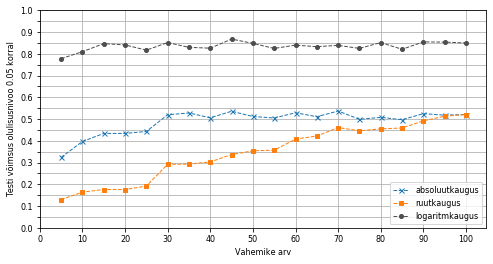

In [3]:
plt.figure(figsize=(8,4))

s=6
m=8
l=12

plt.rc('font', size=s)         
plt.rc('axes', titlesize=l)   
plt.rc('axes', labelsize=m)   
plt.rc('xtick', labelsize=m) 
plt.rc('ytick', labelsize=m)   
plt.rc('legend', fontsize=m)   
plt.rc('figure', titlesize=l)  

colors = ["#1f77b4", "#ff7f0e", "#4E4E4E"] 
labels = ["absoluutkaugus", "ruutkaugus", "logaritmkaugus"]
ms = 4
lw = 1
mabs="x"
msq="s"
mlog="o"

plt.plot(d1["cwes"]["abs"]["bins"], d1["cwes"]["abs"]["quantile at 0.05"], marker='x', linestyle='dashed', markersize=ms+1, label=labels[0], lw=lw, color=colors[0])
plt.plot(d1["cwes"]["sq"]["bins"], d1["cwes"]["sq"]["quantile at 0.05"], marker='s', linestyle='dashed', markersize=ms, label=labels[1], lw=lw, color=colors[1])
plt.plot(d1["cwes"]["log"]["bins"], d1["cwes"]["log"]["quantile at 0.05"], marker='o', linestyle='dashed', markersize=ms, label=labels[2], lw=lw, color=colors[2])

plt.legend(loc="lower right")
plt.grid()
plt.xlabel("Vahemike arv")
plt.ylabel("Testi võimsus olulisusnivoo 0.05 korral")


plt.xticks(ticks=np.arange(0, 100.1, step=10))
plt.yticks(ticks=np.arange(0, 1.01, step=0.05), labels=[0.0, "", 0.1, "",0.2, "", 0.3, "",0.4, "", 0.5, "",0.6, "", 0.7, "",0.8, "", 0.9, "",1.0])
#plt.title("Katse 1. 2 klassi. Meetod 1. Dir(0.1, 0.1). Alpha=0.95")

plt.savefig("graph10.png",bbox_inches='tight', dpi=600)

plt.show()

# Graph 11 and 13

In [14]:
def graph_all_data(data_es, data_ew, quantiles, titles, name):
    data_ew = [x.drop(12) for x in data_ew]
    q = {1 : "quantile at 0.05", 9 : "quantile at 0.95", 0:"mean"}
    
    def plot(row, column, x, y, quantile, marker, label, color,ms):
        if q[quantile] == "quantile at 0.95":
            axs[row, column].plot(x, 1-y[q[quantile]], marker=marker, linestyle="dashed", lw=lw, markersize=ms, label=label, color=color)
        else:
            axs[row, column].plot(x, y[q[quantile]], marker=marker, linestyle="dashed", lw=lw, markersize=ms, label=label, color=color)

    
    colors = ["#1f77b4", "#ff7f0e", "#4E4E4E"] 
    labels = ["absoluutkaugus", "ruutkaugus", "logaritmkaugus"]
    labels2 = ["abs", "square", "log"]
    s = 6
    m = 8
    l = 12
    
    plt.rc('font', size=s)          
    plt.rc('axes', titlesize=s)    
    plt.rc('axes', labelsize=m)    
    plt.rc('xtick', labelsize=s)    
    plt.rc('ytick', labelsize=s)    
    plt.rc('legend', fontsize=m)  
    plt.rc('figure', titlesize=l) 
    
    fig, axs = plt.subplots(9, 2, sharey=True, sharex="col", figsize=(6,9), gridspec_kw={'width_ratios': [8, 10]},
                           constrained_layout=True)
    
    data_ew_ticks = [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.6]
    data_es_ticks = [i for i in np.arange(0.05, 1.01, 0.05)]
    
    ms = 2
    lw = 0.5
    mabs="x"
    msq="s"
    mlog="o"
    
    for i in range(9):
        axs[i,0].set_title(titles[i], x=0.5)
        
        plot(i, 0, data_es_ticks, data_es[0+i*3], quantiles[i][0], mabs, labels[0], colors[0],ms+1)
        plot(i, 1, data_ew_ticks, data_ew[0+i*3], quantiles[i][0], mabs, labels2[0], colors[0],ms+1)
        plot(i, 0, data_es_ticks, data_es[1+i*3], quantiles[i][1], msq, labels[1], colors[1],ms)
        plot(i, 1, data_ew_ticks, data_ew[1+i*3], quantiles[i][1], msq, labels2[2], colors[1],ms)
        plot(i, 0, data_es_ticks, data_es[2+i*3], quantiles[i][2], mlog, labels[2], colors[2],ms)
        plot(i, 1, data_ew_ticks, data_ew[2+i*3], quantiles[i][2], mlog, labels2[2], colors[2],ms)

        x_ticks = np.arange(0, 1.01, step=0.10)
        axs[i,0].set_xticks(x_ticks)
        axs[i,1].set_xticks([0.05, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.6])
        axs[i,0].set_xticklabels([0,10,20,30,40,50,60,70,80,90,100])
        axs[i,1].set_xticklabels([5, 25, 50 ,75, 100, 125, 150, 175, 200, 500])

    axs[1,0].set_yticks(np.arange(0.0, 1.01, 0.25))
    
    lines = [mlines.Line2D([], [], color=colors[0], marker=mabs, markersize=ms+1, label='absoluutkaugus', linestyle="dashed", lw=lw),
            mlines.Line2D([], [], color=colors[1], marker=msq, markersize=ms, label='ruutkaugus', linestyle="dashed", lw=lw),
            mlines.Line2D([], [], color=colors[2], marker=mlog, markersize=ms, label='logaritmkaugus', linestyle="dashed", lw=lw)]
    lgd = fig.legend(handles=lines, loc=8, ncol=3, markerscale=1.2, bbox_to_anchor=(0.5,-0.01), frameon=False)
    
    for ax in axs:
        ax[0].grid()
        ax[1].grid()
    
    plt.savefig(name,bbox_inches='tight', dpi=600,  bbox_extra_artists=(lgd,))
    plt.show()

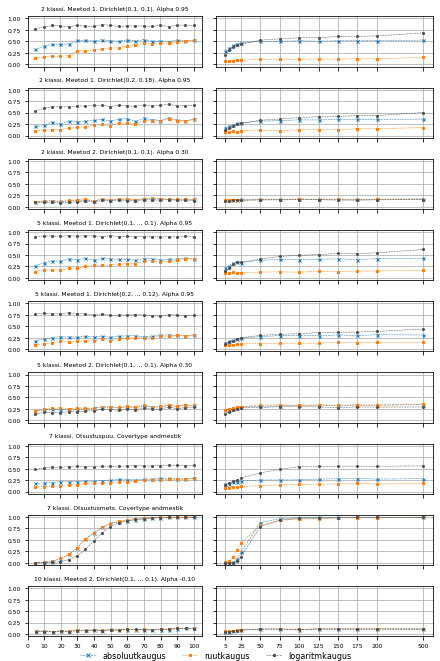

In [18]:
d = [d1, d2, d3, d4, d5, d6, d7, d8, d9]

data_es = []
for i in range(9):
    data_es.append(d[i]["cwes"]["abs"])
    data_es.append(d[i]["cwes"]["sq"])
    data_es.append(d[i]["cwes"]["log"])


data_ew = []
for i in range(9):
    data_ew.append(d[i]["cwew"]["abs"])
    data_ew.append(d[i]["cwew"]["sq"])
    data_ew.append(d[i]["cwew"]["log"])

quantiles = [(1,1,1), 
             (1,1,1), 
             (1,1,1), 
             (1,1,1), 
             (1,1,1), 
             (1,1,1), 
             (1,1,1), 
             (9,9,9), 
             (9,9,9)
            ]

titles = ["2 klassi. Meetod 1. Dirichlet(0.1, 0.1). Alpha 0.95",
         "2 klassi. Meetod 1. Dirichlet(0.2, 0.18). Alpha 0.95",
         "2 klassi. Meetod 2. Dirichlet(0.1, 0.1). Alpha 0.30",
         "5 klassi. Meetod 1. Dirichlet(0.1, .., 0.1). Alpha 0.95",
         "5 klassi. Meetod 1. Dirichlet(0.2, .., 0.12). Alpha 0.95",
         "5 klassi. Meetod 2. Dirichlet(0.1, .., 0.1). Alpha 0.30",
         "7 klassi. Otsustuspuu. Covertype andmestik",
         "7 klassi. Otsustusmets. Covertype andmestik",
         "10 klassi. Meetod 2. Dirichlet(0.1, .., 0.1). Alpha -0.10"]

graph_all_data(data_es, data_ew, quantiles, titles, "graph11.png")

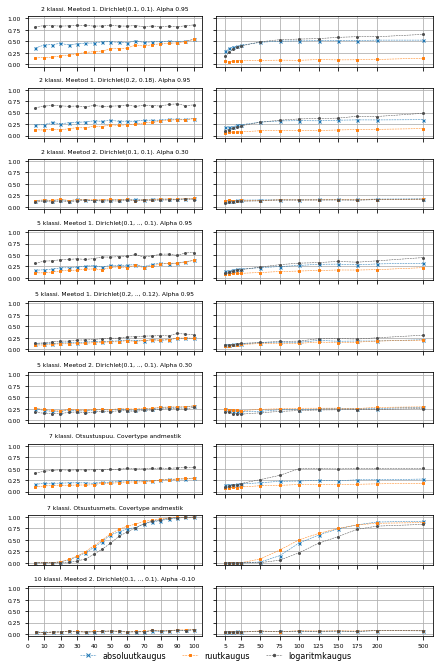

In [20]:
data_es = []
for i in range(9):
    data_es.append(d[i]["cfes"]["abs"])
    data_es.append(d[i]["cfes"]["sq"])
    data_es.append(d[i]["cfes"]["log"])


data_ew = []
for i in range(9):
    data_ew.append(d[i]["cfew"]["abs"])
    data_ew.append(d[i]["cfew"]["sq"])
    data_ew.append(d[i]["cfew"]["log"])

quantiles = [(1,1,1), 
             (1,1,1), 
             (1,1,1), 
             (1,1,1), 
             (1,1,1), 
             (1,1,1), 
             (1,1,1), 
             (9,9,9), 
             (9,9,9)
            ]


titles = ["2 klassi. Meetod 1. Dirichlet(0.1, 0.1). Alpha 0.95",
         "2 klassi. Meetod 1. Dirichlet(0.2, 0.18). Alpha 0.95",
         "2 klassi. Meetod 2. Dirichlet(0.1, 0.1). Alpha 0.30",
         "5 klassi. Meetod 1. Dirichlet(0.1, .., 0.1). Alpha 0.95",
         "5 klassi. Meetod 1. Dirichlet(0.2, .., 0.12). Alpha 0.95",
         "5 klassi. Meetod 2. Dirichlet(0.1, .., 0.1). Alpha 0.30",
         "7 klassi. Otsustuspuu. Covertype andmestik",
         "7 klassi. Otsustusmets. Covertype andmestik",
         "10 klassi. Meetod 2. Dirichlet(0.1, .., 0.1). Alpha -0.10"]

graph_all_data(data_es, data_ew, quantiles, titles, "graph13.png")

# Graph 12

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.colors import ListedColormap
import math

In [23]:
def abs_diff(pred, real_dist):                  
    return 2*(pred[0]*(real_dist[1]-pred[1]) + pred[1]*(real_dist[0]-pred[0]))

def sq_diff(pred, real_dist):                  
    return 2*(pred[0]*pred[0]*(real_dist[1]-pred[1]) + pred[1]*pred[1]*(real_dist[0]-pred[0]))

def log_diff(pred, real_dist):
    def log(avg_pred, real_prop):
        if real_prop == avg_pred:
            return  0
        elif real_prop < 1 and avg_pred == 1:
            return 99999
        elif real_prop > 0 and avg_pred == 0:
            return 99999
        else:
            if real_prop == 0:
                first_log = 0
            else:
                first_log = real_prop * math.log(real_prop / avg_pred)
            if real_prop == 1:
                second_log = 0
            else:
                second_log = (1.0-real_prop) * math.log((1.0-real_prop) / (1.0-avg_pred))
        return (first_log + second_log)
    log_real = (real_dist[0] * (log(pred[0], 1) + log(pred[1], 0)) +\
                      real_dist[1] * (log(pred[0], 0) + log(pred[1], 1)))
    log_perf = (pred[0] * (log(pred[0], 1) + log(pred[1], 0)) +\
                      pred[1] * (log(pred[0], 0) + log(pred[1], 1)))
    
    return log_real - log_perf

# @author: http://chris35wills.github.io/matplotlib_diverging_colorbar/
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [24]:
X = np.arange(0, 1.001, 0.01)
Y = np.arange(1.001, -0.001, -0.01)
X, Y = np.meshgrid(X, Y)

Z_abs = []
for row_index in range(len(X)):
    row_Z = []
    for column_index in range(len(X[row_index])):
        row_Z.append(abs_diff([X[row_index][column_index], 1-X[row_index][column_index]],
                             [Y[row_index][column_index], 1-Y[row_index][column_index]]))
    Z_abs.append(row_Z)
Z_abs=np.asarray(Z_abs)

Z_log = []
for row_index in range(len(X)):
    row_Z = []
    for column_index in range(len(X[row_index])):
        row_Z.append(log_diff([X[row_index][column_index], 1-X[row_index][column_index]],
                             [Y[row_index][column_index], 1-Y[row_index][column_index]]))
    Z_log.append(row_Z)
Z_log=np.asarray(Z_log)

Z_sq = []
for row_index in range(len(X)):
    row_Z = []
    for column_index in range(len(X[row_index])):
        row_Z.append(sq_diff([X[row_index][column_index], 1-X[row_index][column_index]],
                             [Y[row_index][column_index], 1-Y[row_index][column_index]]))
    Z_sq.append(row_Z)
Z_sq=np.asarray(Z_sq)

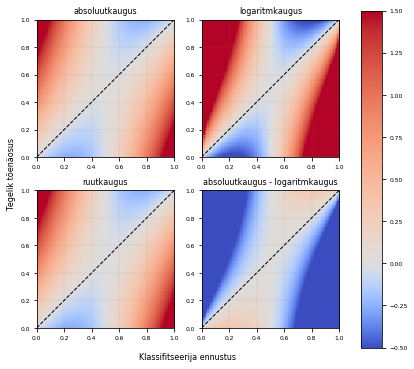

In [27]:
fig = plt.figure(figsize=(6,6))

s=6
m=8
l=12

plt.rc('font', size=s)  
plt.rc('axes', titlesize=m)     
plt.rc('axes', labelsize=m)  
plt.rc('xtick', labelsize=s)  
plt.rc('ytick', labelsize=s)    
plt.rc('legend', fontsize=s)    
plt.rc('figure', titlesize=l)  


ax = fig.add_subplot(111)   
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)


cmap=plt.cm.get_cmap('coolwarm')
#cmap = ListedColormap(cmap(np.linspace(0.0, 1.0, 21)))
elev_min=-0.5
elev_max=1.5
mid_val=0

im1 = ax1.imshow(Z_abs, extent=[0,1,0,1], cmap=cmap, clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
im2 = ax2.imshow(Z_log, extent=[0,1,0,1], cmap=cmap, clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
im3 = ax3.imshow(Z_sq, extent=[0,1,0,1], cmap=cmap, clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
im4 = ax4.imshow(Z_abs-Z_log, extent=[0,1,0,1], cmap=cmap, clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

ax1.grid(True, which='both', color='grey', linestyle='-', linewidth=0.1)
ax1.plot([0, 1], [0, 1], color="black", linestyle='dashed', linewidth=1.0)
ax2.grid(True, which='both', color='grey', linestyle='-', linewidth=0.1)
ax2.plot([0, 1], [0, 1], color="black", linestyle='dashed', linewidth=1.0)
ax3.grid(True, which='both', color='grey', linestyle='-', linewidth=0.1)
ax3.plot([0, 1], [0, 1], color="black", linestyle='dashed', linewidth=1.0)
ax4.grid(True, which='both', color='grey', linestyle='-', linewidth=0.1)
ax4.plot([0, 1], [0, 1], color="black", linestyle='dashed', linewidth=1.0)

xticks = np.round(np.arange(0, 1.001, 0.2),2)
plt.setp(ax1, xticks=xticks, xticklabels=xticks,
        yticks=xticks)

plt.setp(ax2, xticks=xticks, xticklabels=xticks,
        yticks=xticks)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.1, 0.05, 0.78])
fig.colorbar(im1, cax=cbar_ax)

ax.set_xlabel('Klassifitseerija ennustus')
ax.set_ylabel('Tegelik tõenäosus')
ax1.set_title('absoluutkaugus')
ax2.set_title('logaritmkaugus')
ax3.set_title('ruutkaugus')
ax4.set_title('absoluutkaugus - logaritmkaugus')


plt.subplots_adjust(hspace=0.1, left=0.1)
plt.savefig("graph12.png",bbox_inches='tight', dpi=600)

plt.show()